# Intial transfer learning CNN modeling in PyTorch

Adapted from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [133]:
# Import basics
import os
import numpy as np
import time
import copy

# Import PyTorch
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# Import torchvision 
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, ConcatDataset

# Import torchmetrics
import torchmetrics

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.12.1
torchvision version: 0.13.1


In [19]:
cudnn.benchmark = True
plt.ion()   # interactive mode

## PyTorch data setup

Set dataset and image path

In [20]:
dataset = 'Data_CMC_MEL_1'
image_path = '/Users/gsowell/Desktop/Research/Fourthbrain/Capstone/samsung-capstone/assignments/week-7-initial-github/'+dataset
train_dir = image_path+'/train'
test_dir = image_path+'/test'

### Define PyTorch transform

In [21]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    #transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

### Create PyTorch dataloaders

**Hyperparameters**

In [77]:
batch_size = 64
num_workers = os.cpu_count()
random_state = 42

Load in data

In [23]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

Randomly split train data into training and validation sets

In [145]:
train_split = 0.7
training_examples = int(len(train_data)*train_split)
val_examples = len(train_data) - training_examples


In [146]:
train, val = torch.utils.data.random_split((train_data), 
                                            [training_examples, val_examples], 
                                                generator=torch.Generator().manual_seed(random_state))

Create dictionary of train, validation, and test sets and specify whether to shuffle the data in the dataloader

In [147]:
image_datasets = {'train': [train, True],
                    'val': [val, True],
                        'test': [test_data, False]} # usually don't shuffle test data

dataset_sizes = {x: len(image_datasets[x][0]) for x in ['train','val','test']}

K-fold cross validation setup

In [149]:
from sklearn.model_selection import KFold

k = 5
dataset = ConcatDataset([train_data, test_data])
splits=KFold(n_splits=k,shuffle=True,random_state=random_state)


Create dataloaders

In [150]:
dataloaders = {x: DataLoader(image_datasets[x][0], 
                                batch_size=batch_size, 
                                    num_workers=num_workers, 
                                        shuffle=image_datasets[x][1])
                for x in ['train','val','test']}

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=False) # don't usually need to shuffle testing data

### Visualize data

In [151]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [152]:
# Get a batch of training data and subset to just 4 examples
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4]

In [153]:
# Get class names
class_names = train_data.classes

In [154]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

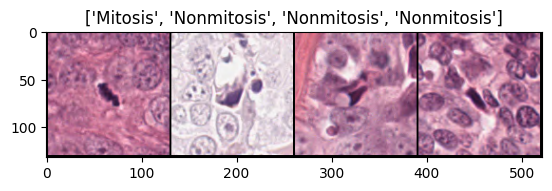

In [155]:
imshow(out, title=[class_names[x] for x in classes])

## PyTorch modeling

**Hyperparameters**

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = 2
learning_rate = 0.01
momentum = 0.9
step_size = 7
gamma = 0.1

### Model training definition

In [158]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning pre-trained ResNet-18 model

Load in pre-trained model and reset the fully connected layer

In [142]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by factor 'gamma' every 'step_size' epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

/Users/gsowell/anaconda3/envs/capstone/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/gsowell/anaconda3/envs/capstone/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)